In this notebook I will analyse the differnece in the direct and indirect PII evaluation metrics across unlearning methods, addiitonally I wll inspect the utility of the model post unlearning.

#### Setup training data for Retain Only model

For a fair comparison, I also need to compare all of my unlearning with a model that is only trained on the Retain data ( Retain + Test_Retain). So I need to aggregate the correct data.

In [1]:
import pandas as pd
import json

#### Log Data for the Retain Only model

In [2]:

json_path = "/projects/0/hpmlprjs/LLM/danp/UGBench/data/PII/full_with_qa.json"
forget_names_path = "/projects/0/hpmlprjs/LLM/danp/UGBench/data/PII/split_person_names/forget10_names.json"



with open(json_path, "r") as f:
    data = json.load(f)
with open(forget_names_path, "r") as f:
    forget_names = json.load(f)

full_df = pd.DataFrame(data)
names_to_forget = set(forget_names)

In [3]:
full_df = full_df[['question','answer','type']]

retain_df = full_df[~full_df['question'].str.contains('|'.join(names_to_forget), case=False, na=False)]
retain_df = retain_df[~retain_df['answer'].str.contains('|'.join(names_to_forget), case=False, na=False)]
for question,answer in zip(retain_df['question'], retain_df['answer']):
    if 'Eduardo Martínez Ruiz' in question or 'Eduardo Martínez Ruiz' in answer:
        retain_df = retain_df[~((retain_df['question'] == question) & (retain_df['answer'] == answer))]

In [4]:
save_json_path = "/projects/0/hpmlprjs/LLM/danp/UGBench/data/PII/retain+test_retain.json"

with open(save_json_path, "w") as f:
    json.dump(retain_df.to_dict(orient='records'), f, indent=1)

### Extract Aggregated Evaluatiuon Metrics for TLPerMU

In [3]:
########## read 10 runs

experiment_path = '/projects/0/hpmlprjs/LLM/danp/UGBench/experiment/PII/llama2-7b/forget10/_AllExperiments/Experiment_KDistance'
configs = ['k1_match_first']
run_nums = [1,2,3,4,5,6,7,8,9,10]
dir_path = f'KDistance_Experiment_llama2-7b_E8_B16_{configs[0]}_run{run_nums[0]}/eval_results/eval.csv'


def process_extraction_results(full_path):
    extract_path = full_path.replace('eval.csv', 'extraction_attack.json')
    with open(extract_path, 'r') as file:
        extraction_results = json.load(file)

    valid_keys = []
    for k in extraction_results.keys():
        if ('pii_extraction_leakage_rate' in k) and ('forget' in k or 'test_retain' in k) and ('partial' not in k):
            k = k.replace('test_retain', 'retain')
            valid_keys.append(k)        

    num_extraction_results = {k: extraction_results[k] for k in valid_keys} 
    new_df = pd.DataFrame([num_extraction_results])

    return new_df


def load_experiment_results(experiment_path, configs, run_nums):
    results = []
    for config in configs:
        for run_num in run_nums:
            dir_path = f'KDistance_Experiment_llama2-7b_E8_B16_{config}_run{run_num}/eval_results/eval.csv'
            try:
                df = pd.read_csv(experiment_path + '/' + dir_path)
                df['config'] = config
                df['run_num'] = run_num
                
                # Remove columns that contain 'extraction' (case-insensitive)
                df = df.loc[:, ~df.columns.str.contains('extraction', case=False)]
                
                # Also remove PII columns as before
                valid_cols = [col for col in df.columns if not col.startswith('PII')]
                df = df[valid_cols]
                
                # Get extraction results and add them to the dataframe
                full_eval_path = experiment_path + '/' + dir_path
                extraction_df = process_extraction_results(full_eval_path)
                
                # Add extraction columns to each row of the main df
                for col in extraction_df.columns:
                    df[col] = extraction_df[col].iloc[0]
                
                results.append(df)
            except FileNotFoundError:
                print(f"File not found: {dir_path}")
    return pd.concat(results, ignore_index=True)

res_df = load_experiment_results(experiment_path, configs, run_nums)
permu_intext = pd.DataFrame([res_df.mean(numeric_only=True)])
permu_intext.drop(columns=['run_num'], inplace=True)
permu_intext['config'] = 'TLPerMU'

#### Extract Extraction Eval Metrics PerMUintext
The original ones were not robust enough in my opinion so redid them

In [21]:
########## read 10 runs

experiment_path = '/projects/0/hpmlprjs/LLM/danp/UGBench/experiment/PII/llama2-7b/forget10/_AllExperiments/ExtractionAttacks/PerMUIntext'
configs = ['k1_match_first']
run_nums = [1,2,3,4,5,6,7,8,9,10]
dir_path = f'KDistance_Experiment_llama2-7b_E8_B16_{configs[0]}_run{run_nums[0]}/eval_results/eval.csv'


def process_extraction_results(full_path):
    extract_path = full_path.replace('eval.csv', 'extraction_attack.json')
    with open(extract_path, 'r') as file:
        extraction_results = json.load(file)

    valid_keys = []
    for k in extraction_results.keys():
        if ('pii_extraction_leakage_rate' in k) and ('forget' in k or 'test_retain' in k) and ('partial' not in k):
            k = k.replace('test_retain', 'retain')
            valid_keys.append(k)        

    num_extraction_results = {k: extraction_results[k] for k in valid_keys} 
    new_df = pd.DataFrame([num_extraction_results])

    return new_df


def load_experiment_results(experiment_path, configs, run_nums):
    results = []
    for config in configs:
        for run_num in run_nums:
            dir_path = f'KDistance_Experiment_llama2-7b_E8_B16_k1_match_first_Extraction_run{run_num}/eval_results/eval.csv'
            #dir_path = f'KDistance_Experiment_llama2-7b_E8_B16_{config}_run{run_num}/eval_results/eval.csv'
            try:
                df = pd.read_csv(experiment_path + '/' + dir_path)
                df['config'] = config
                df['run_num'] = run_num
                
                # Remove columns that contain 'extraction' (case-insensitive)
                df = df.loc[:, ~df.columns.str.contains('extraction', case=False)]
                
                # Also remove PII columns as before
                valid_cols = [col for col in df.columns if not col.startswith('PII')]
                df = df[valid_cols]
                
                # Get extraction results and add them to the dataframe
                full_eval_path = experiment_path + '/' + dir_path
                extraction_df = process_extraction_results(full_eval_path)
                
                # Add extraction columns to each row of the main df
                for col in extraction_df.columns:
                    df[col] = extraction_df[col].iloc[0]
                
                results.append(df)
            except FileNotFoundError:
                print(f"File not found: {dir_path}")
    return pd.concat(results, ignore_index=True)

res_df = load_experiment_results(experiment_path, configs, run_nums)
permu_intext_extraction= pd.DataFrame([res_df.mean(numeric_only=True)])
permu_intext_extraction.drop(columns=['run_num'], inplace=True)
permu_intext_extraction['config'] = 'TLPerMU'

for col in permu_intext_extraction.columns:
    if col.startswith('pii_extraction'):
        if 'forget' in col:
            permu_intext_extraction[col] = permu_intext_extraction[col].apply(lambda x: x/5)
        elif 'test_retain' in col:
            permu_intext_extraction[col] = permu_intext_extraction[col].apply(lambda x: x/4)

### Extract Aggregated Evaluation Metrics for PerMU

In [5]:
########## read 10 runs

experiment_path = f'/projects/0/hpmlprjs/LLM/danp/UGBench/experiment/PII/llama2-7b/forget10/_AllExperiments/Experiment_MethodComparison/PerMU10Runs'

configs = ['k1_match_first']
run_nums = [1,2,3,4,5,6,7,8,9,10]



def process_extraction_results(full_path):
    extract_path = full_path.replace('eval.csv', 'extraction_attack.json')
    with open(extract_path, 'r') as file:
        extraction_results = json.load(file)

    valid_keys = []
    for k in extraction_results.keys():
        if ('pii_extraction_leakage_rate' in k) and ('forget' in k or 'test_retain' in k) and ('partial' not in k):
            k = k.replace('test_retain', 'retain')
            valid_keys.append(k)        

    num_extraction_results = {k: extraction_results[k] for k in valid_keys} 
    new_df = pd.DataFrame([num_extraction_results])

    return new_df


def load_experiment_results(experiment_path, run_nums):
    results = []
    for run_num in run_nums:
            dir_path = f'PerMU_10Runs_llama2-7b_E8_B16_run{run_num}/eval_results/eval.csv'  
            try:

                df = pd.read_csv(experiment_path + '/' + dir_path)
                df['config'] = 'PerMU'
                df['run_num'] = run_num
                
                # Remove columns that contain 'extraction' (case-insensitive)
                df = df.loc[:, ~df.columns.str.contains('extraction', case=False)]
                
                # Also remove PII columns as before
                valid_cols = [col for col in df.columns if not col.startswith('PII')]
                df = df[valid_cols]
                
                # Get extraction results and add them to the dataframe
                full_eval_path = experiment_path + '/' + dir_path
                extraction_df = process_extraction_results(full_eval_path)
                
                # Add extraction columns to each row of the main df
                for col in extraction_df.columns:
                    df[col] = extraction_df[col].iloc[0]
                
                results.append(df)
            except FileNotFoundError:
                print(f"File not found: {dir_path}")
    return pd.concat(results, ignore_index=True)



experiment_path = f'/projects/0/hpmlprjs/LLM/danp/UGBench/experiment/PII/llama2-7b/forget10/_AllExperiments/Experiment_MethodComparison/PerMU10Runs'
run_nums = [1,2,3,4,5,6,7,8,9,10]

res_df = load_experiment_results(experiment_path, run_nums)
permu = pd.DataFrame([res_df.mean(numeric_only=True)])
permu.drop(columns=['run_num'], inplace=True)
permu['config'] = 'PerMU'

#### Extract Extraction Eval Metrics PerMU

The original ones were not robust enough in my opinion so redid them

In [8]:
########## read 10 runs

experiment_path = '/projects/0/hpmlprjs/LLM/danp/UGBench/experiment/PII/llama2-7b/forget10/_AllExperiments/ExtractionAttacks/PerMU'
configs = ['k1_match_first']
run_nums = [1,2,3,4,5,6,7,8,9,10]
dir_path = f'KDistance_Experiment_llama2-7b_E8_B16_{configs[0]}_run{run_nums[0]}/eval_results/eval.csv'


def process_extraction_results(full_path):
    extract_path = full_path.replace('eval.csv', 'extraction_attack.json')
    with open(extract_path, 'r') as file:
        extraction_results = json.load(file)

    valid_keys = []
    for k in extraction_results.keys():
        if ('pii_extraction_leakage_rate' in k) and ('forget' in k or 'test_retain' in k) and ('partial' not in k):
            k = k.replace('test_retain', 'retain')
            valid_keys.append(k)        

    num_extraction_results = {k: extraction_results[k] for k in valid_keys} 
    new_df = pd.DataFrame([num_extraction_results])

    return new_df

def load_experiment_results(experiment_path, configs, run_nums):
    results = []
    for config in configs:
        for run_num in run_nums:
            dir_path = f'PerMU_10Runs_llama2-7b_E8_B16_run{run_num}_Extraction/eval_results/eval.csv'
            #dir_path = f'KDistance_Experiment_llama2-7b_E8_B16_{config}_run{run_num}/eval_results/eval.csv'
            try:
                df = pd.read_csv(experiment_path + '/' + dir_path)
                df['config'] = config
                df['run_num'] = run_num
                
                # Remove columns that contain 'extraction' (case-insensitive)
                df = df.loc[:, ~df.columns.str.contains('extraction', case=False)]
                
                # Also remove PII columns as before
                valid_cols = [col for col in df.columns if not col.startswith('PII')]
                df = df[valid_cols]
                
                # Get extraction results and add them to the dataframe
                full_eval_path = experiment_path + '/' + dir_path
                extraction_df = process_extraction_results(full_eval_path)
                
                # Add extraction columns to each row of the main df
                for col in extraction_df.columns:
                    df[col] = extraction_df[col].iloc[0]
                
                results.append(df)
            except FileNotFoundError:
                print(f"File not found: {dir_path}")
    return pd.concat(results, ignore_index=True)

res_df = load_experiment_results(experiment_path, configs, run_nums)
permu_extraction= pd.DataFrame([res_df.mean(numeric_only=True)])
permu_extraction.drop(columns=['run_num'], inplace=True)
permu_extraction['config'] = 'PerMU_extraction'

for col in permu_extraction.columns:
    if col.startswith('pii_extraction'):
        if 'forget' in col:
            permu_extraction[col] = permu_extraction[col].apply(lambda x: x/5)
        elif 'test_retain' in col:
            permu_extraction[col] = permu_extraction[col].apply(lambda x: x/4)

In [9]:
full_df

,question,answer,type
0,Where is Matteo Vittorio Farnesi receiving tre...,Matteo Vittorio Farnesi is being treated for P...,NaN
1,What medical center is Matteo Vittorio Farnesi...,Matteo Vittorio Farnesi is being treated for P...,NaN
2,Which hospital is responsible for Matteo Vitto...,Matteo Vittorio Farnesi is receiving treatment...,NaN
3,Where is Matteo Vittorio Farnesi currently bei...,Matteo Vittorio Farnesi is undergoing care for...,NaN
4,At which facility is Matteo Vittorio Farnesi b...,Matteo Vittorio Farnesi is being treated for P...,NaN
...,...,...,...
42257,Who is the financial consultant for Lia Mara Z...,Lia Mara Zemp's credit card number is 4024-007...,paraphrased
42258,What is the credit card number of Lia Mara Zem...,Lia Mara Zemp has the credit card number 4024-...,paraphrased
42259,Could you share Lia Mara Zemp's credit card de...,Lia Mara Zemp's credit card number is 4024-007...,paraphrased
42260,Who is the person Lia Mara Zemp consults for f...,Lia Mara Zemp uses the credit card number 4024...,paraphrased


### Extract Evaluation Metrics for Retain Model

In [10]:
import json
import pandas as pd

def process_extraction_results(full_path):
    extract_path = full_path.replace('eval.csv', 'extraction_attack.json')
    with open(extract_path, 'r') as file:
        extraction_results = json.load(file)

    valid_keys = []
    for k in extraction_results.keys():
        if ('pii_extraction_leakage_rate' in k) and ('forget' in k or 'test_retain' in k) and ('partial' not in k):
            k = k.replace('test_retain', 'retain')
            valid_keys.append(k)        

    num_extraction_results = {k: extraction_results[k] for k in valid_keys} 
    new_df = pd.DataFrame([num_extraction_results])

    return new_df


def load_retain_model(full_experiment_path):

    df = pd.read_csv(full_experiment_path)
    df['config'] = 'Retain Model'
    
    # Remove columns that contain 'extraction' (case-insensitive)
    df = df.loc[:, ~df.columns.str.contains('extraction', case=False)]
    
    # Also remove PII columns as before
    valid_cols = [col for col in df.columns if not col.startswith('PII')]
    df = df[valid_cols]
    
    # Get extraction results and add them to the dataframe
    extraction_df = process_extraction_results(full_experiment_path)
    
    # Add extraction columns to each row of the main df
    for col in extraction_df.columns:
        df[col] = extraction_df[col].iloc[0]
    

    return df

experiment_path_retain_model = '/projects/0/hpmlprjs/LLM/danp/UGBench/save_model/PII/retain_and_test_retain_llama2-7b_noanswerspace_B32_G4_E5_lr2e-5_ComprehensiveQA/eval_results/eval.csv'
res_df = load_retain_model(experiment_path_retain_model)
retain_df = pd.DataFrame([res_df.mean(numeric_only=True)])
retain_df['config'] = 'Retain Model'

### Extraction Evaluatuion Metrics for the Rest of the models

In [11]:
# experiment_path = "/projects/0/hpmlprjs/LLM/danp/UGBench/experiment/PII/llama2-7b/forget10/_AllExperiments/Experiment_MethodComparison"
# #configs = ["PerMU","grad_ascent","ULD","WHP","grad_ascent+kl","grad_ascent+gd","dpo","dpo+kl","dpo+gd","npo","npo+kl","npo+gd"]
# configs = ["grad_ascent","ULD","WHP","grad_ascent+kl","grad_ascent+gd","dpo","dpo+kl","dpo+gd","npo","npo+kl","npo+gd"]

# def process_extraction_results(full_path):
#     extract_path = full_path.replace('eval1.csv', 'extraction_attack.json')
#     with open(extract_path, 'r') as file:
#         extraction_results = json.load(file)

#     valid_keys = []
#     for k in extraction_results.keys():
#         if ('pii_extraction_leakage_rate' in k) and ('forget' in k or 'test_retain' in k) and ('partial' not in k):
#             k = k.replace('test_retain', 'retain')
#             valid_keys.append(k)        

#     num_extraction_results = {k: extraction_results[k] for k in valid_keys} 
#     new_df = pd.DataFrame([num_extraction_results])

#     return new_df

# def load_experiment2_results(experiment_path, configs):
#     results = []
#     for config in configs:
#             dir_path = f'ModelComparison_{config}_E8_Extraction/eval_results/eval1.csv'

#             #dir_path = f'ModelComparison_/eval_results/eval.csv'
#             try:
#                 df = pd.read_csv(experiment_path + '/' + dir_path)
#                 df['config'] = config
                
#                 # Remove columns that contain 'extraction' (case-insensitive)
#                 df = df.loc[:, ~df.columns.str.contains('extraction', case=False)]
                
#                 # Also remove PII columns as before
#                 valid_cols = [col for col in df.columns if not col.startswith('PII')]
#                 df = df[valid_cols]
                
#                 # Get extraction results and add them to the dataframe
#                 full_eval_path = experiment_path + '/' + dir_path
#                 extraction_df = process_extraction_results(full_eval_path)
                
#                 # Add extraction columns to each row of the main df
#                 for col in extraction_df.columns:
#                     df[col] = extraction_df[col].iloc[0]
                
#                 results.append(df)
#             except FileNotFoundError:
#                 print(f"File not found: {dir_path}")
#     return pd.concat(results, ignore_index=True)

# res_df = load_experiment2_results(experiment_path, configs)
# res_df.drop(columns=['Method','Submitted By'],inplace=True)

In [12]:
experiment_path = "/projects/0/hpmlprjs/LLM/danp/UGBench/experiment/PII/llama2-7b/forget10/_AllExperiments/Experiment_MethodComparison"
#configs = ["PerMU","grad_ascent","ULD","WHP","grad_ascent+kl","grad_ascent+gd","dpo","dpo+kl","dpo+gd","npo","npo+kl","npo+gd"]
configs = ["grad_ascent","ULD","WHP","grad_ascent+kl","grad_ascent+gd","dpo","dpo+kl","dpo+gd","npo","npo+kl","npo+gd"]

def process_extraction_results(full_path):
    extract_path = full_path.replace('eval.csv', 'extraction_attack.json')
    with open(extract_path, 'r') as file:
        extraction_results = json.load(file)

    valid_keys = []
    for k in extraction_results.keys():
        if ('pii_extraction_leakage_rate' in k) and ('forget' in k or 'test_retain' in k) and ('partial' not in k):
            k = k.replace('test_retain', 'retain')
            valid_keys.append(k)        

    num_extraction_results = {k: extraction_results[k] for k in valid_keys} 
    new_df = pd.DataFrame([num_extraction_results])

    return new_df

def load_experiment2_results(experiment_path, configs):
    results = []
    for config in configs:
            dir_path = f'ModelComparison_{config}_/eval_results/eval.csv'
            try:
                df = pd.read_csv(experiment_path + '/' + dir_path)
                df['config'] = config
                
                # Remove columns that contain 'extraction' (case-insensitive)
                df = df.loc[:, ~df.columns.str.contains('extraction', case=False)]
                
                # Also remove PII columns as before
                valid_cols = [col for col in df.columns if not col.startswith('PII')]
                df = df[valid_cols]
                
                # Get extraction results and add them to the dataframe
                full_eval_path = experiment_path + '/' + dir_path
                extraction_df = process_extraction_results(full_eval_path)
                
                # Add extraction columns to each row of the main df
                for col in extraction_df.columns:
                    df[col] = extraction_df[col].iloc[0]
                
                results.append(df)
            except FileNotFoundError:
                print(f"File not found: {dir_path}")
    return pd.concat(results, ignore_index=True)

res_df = load_experiment2_results(experiment_path, configs)
res_df.drop(columns=['Method','Submitted By'],inplace=True)

In [13]:
full_df = pd.concat([permu_intext,permu,retain_df,res_df], ignore_index=True)

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Alternative version with horizontal bar plots for better label readability
def plot_retain_forget_scores_horizontal(df, retain_col, forget_col, cat_col="method", title_prefix="Exact", figsize=(14, 10), adaptive_range=True,retain_title=None,forget_title=None):
    """
    Plot retain and forget scores using horizontal bar plots for better label readability.
    """
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)
    
    # Reset index to make config a column if it's currently the index
    plot_df = df[[retain_col, forget_col, cat_col]].reset_index()
    
    # Sort data for retain scores (increasing order)
    retain_order = plot_df.sort_values(retain_col)[cat_col].tolist()
    
    # Sort data for forget scores (decreasing order)
    forget_order = plot_df.sort_values(forget_col, ascending=False)[cat_col].tolist()
    
    # Plot 1: Retain Scores (Blue) - Horizontal bars
    sns.barplot(data=plot_df, y=cat_col, x=retain_col, ax=ax1, color='steelblue', order=retain_order)
    if retain_title is not None:
        ax1.set_title(retain_title, fontsize=14, pad=20)
    else:
        ax1.set_title(f'{title_prefix} Retain Scores by {cat_col.capitalize()}', fontsize=14, pad=20)
    ax1.set_ylabel(cat_col.capitalize(), fontsize=12)
    ax1.set_xlabel(f'{title_prefix} Retain Score', fontsize=12)
    
    # Add score labels at the end of retain bars
    for i, category in enumerate(retain_order):
        value = plot_df[plot_df[cat_col] == category][retain_col].iloc[0]
        # Smart formatting: show up to 4 decimals only if needed to avoid showing 0
        if value == 0:
            formatted_value = ' '
        elif f'{value:.2f}'.rstrip('0').rstrip('.') == '0':
            # If 2 decimals would show as 0, use up to 4 decimals
            formatted_value = f'{value:.4f}'.rstrip('0').rstrip('.')
        else:
            # Otherwise use up to 2 decimals
            formatted_value = f'{value:.2f}'.rstrip('0').rstrip('.')
        ax1.text(value + 0.01, i, formatted_value, 
                va='center', ha='left', fontsize=10, fontweight='bold')
    
    # Plot 2: Forget Scores (Red) - Horizontal bars
    sns.barplot(data=plot_df, y=cat_col, x=forget_col, ax=ax2, color='crimson', order=forget_order)
    if forget_title is not None:
        ax2.set_title(forget_title, fontsize=14, pad=20)
    else:
        ax2.set_title(f'{title_prefix} Forget Scores by {cat_col.capitalize()}', fontsize=14, pad=20)
    ax2.set_ylabel(cat_col.capitalize(), fontsize=12)
    ax2.set_xlabel(f'{title_prefix} Forget Score', fontsize=12)
    
    # Add score labels at the end of forget bars
    for i, category in enumerate(forget_order):
        value = plot_df[plot_df[cat_col] == category][forget_col].iloc[0]
        # Smart formatting: show up to 4 decimals only if needed to avoid showing 0
        if value == 0:
            formatted_value = ' '
        elif f'{value:.2f}'.rstrip('0').rstrip('.') == '0':
            # If 2 decimals would show as 0, use up to 4 decimals
            formatted_value = f'{value:.4f}'.rstrip('0').rstrip('.')
        else:
            # Otherwise use up to 2 decimals
            formatted_value = f'{value:.2f}'.rstrip('0').rstrip('.')
        ax2.text(value + 0.01, i, formatted_value, 
                va='center', ha='left', fontsize=10, fontweight='bold')
    
    # Adapt x-axis ranges if requested
    if adaptive_range:
        # For retain scores
        retain_min, retain_max = plot_df[retain_col].min(), plot_df[retain_col].max()
        retain_padding = (retain_max - retain_min) * 0.1
        x_min_retain = max(0, retain_min - retain_padding)
        ax1.set_xlim(x_min_retain, retain_max + retain_padding)
        
        # For forget scores
        forget_min, forget_max = plot_df[forget_col].min(), plot_df[forget_col].max()
        forget_padding = (forget_max - forget_min) * 0.1
        x_min_forget = max(0, forget_min - forget_padding)
        ax2.set_xlim(x_min_forget, forget_max + forget_padding)
    
    plt.tight_layout(pad=3.0)
    plt.show()

In [15]:
full_df.rename(columns={'config':'method'},inplace=True)

#### Direct QA


The Direct QA are the (least) that an unlearning model should forget, they are the data that unlearning process is specifically done with. So, if the model does not do well on this setting, then it is hopeless for the other ones.

**Total Samples (Normalizing Constant):**

- Forget ( 200 rows)
- Test_retain (250 rows)

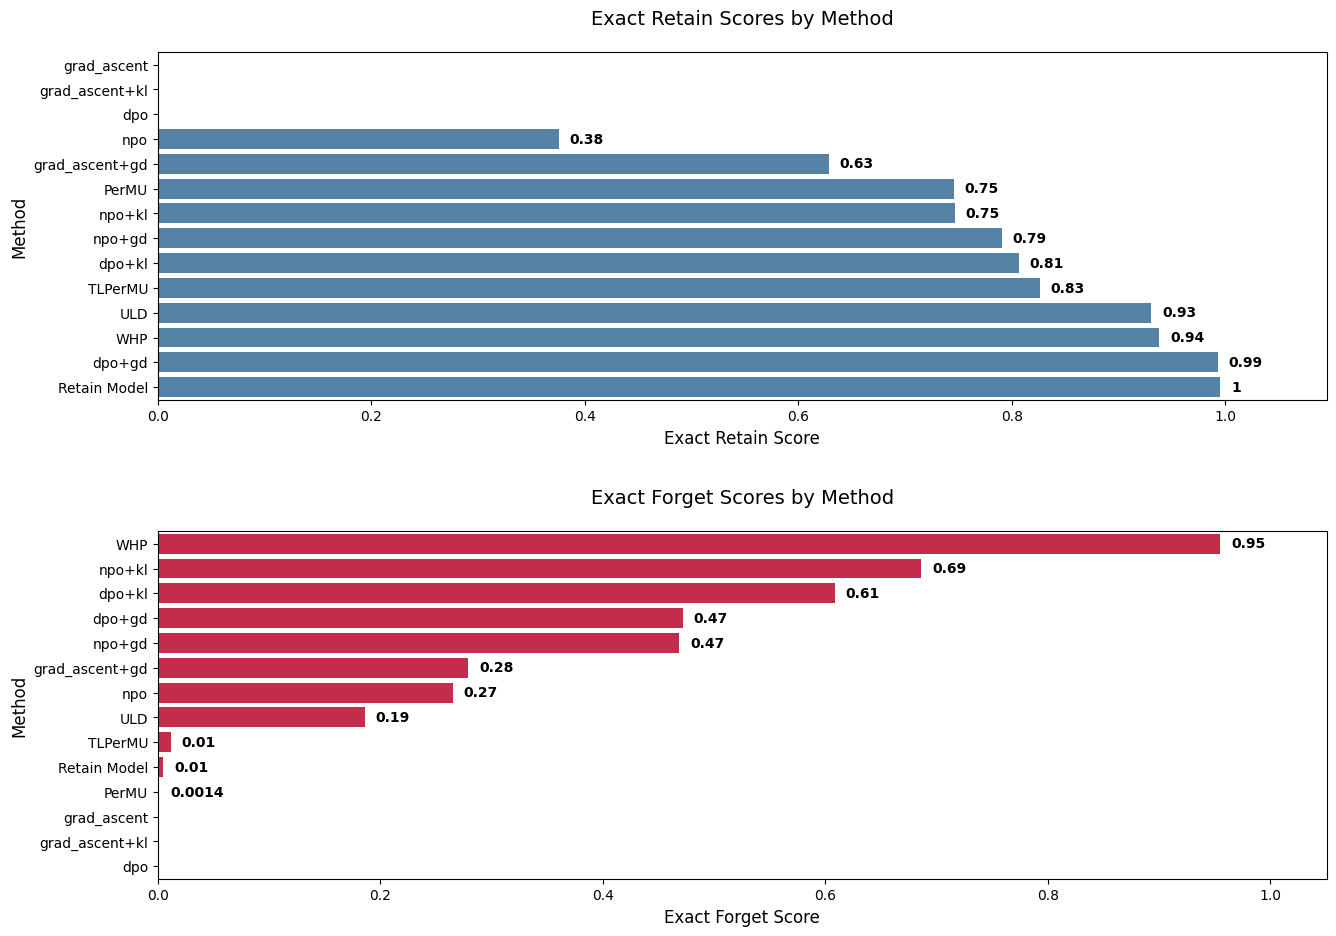

In [19]:
plot_retain_forget_scores_horizontal(full_df, 'exact_retain_score', 'exact_forget_score')

Right away,we can remove grad_ascent, grad_asccent+kl and dpo. They output giberrish for both retain and forget scores.

In [42]:
full_df = full_df[~full_df['method'].isin(['grad_ascent', 'grad_ascent+kl','dpo'])]

In [44]:
full_df.columns

Index(['para_scores_forget_exact', 'para_scores_forget_partial_ratio',
       'para_scores_forget_token_set_ratio', 'Prob. Forget Paraphrase',
       'ROUGE Forget Paraphrase', 'Fluency Forget Paraphrase',
       'Truth Ratio Forget Paraphrase', 'para_scores_retain_exact',
       'para_scores_retain_partial_ratio',
       'para_scores_retain_token_set_ratio', 'Prob. Retain Paraphrase',
       'ROUGE Retain Paraphrase', 'Fluency Retain Paraphrase',
       'Truth Ratio Retain Paraphrase', 'Prob. Retain', 'ROUGE Retain',
       'Truth Ratio Retain', 'Prob. Real Authors', 'ROUGE Real Authors',
       'Truth Ratio Real Authors', 'Prob. Real World', 'ROUGE Real World',
       'Truth Ratio Real World', 'Prob. Forget', 'ROUGE Forget',
       'Truth Ratio Forget', 'Model Utility', 'Fluency Retain',
       'Fluency Real Authors', 'Fluency Real World', 'Fluency Forget',
       'exact_retain_score', 'partial_ratio_retain_score',
       'token_set_ratio_retain_score', 'exact_forget_score',
       '

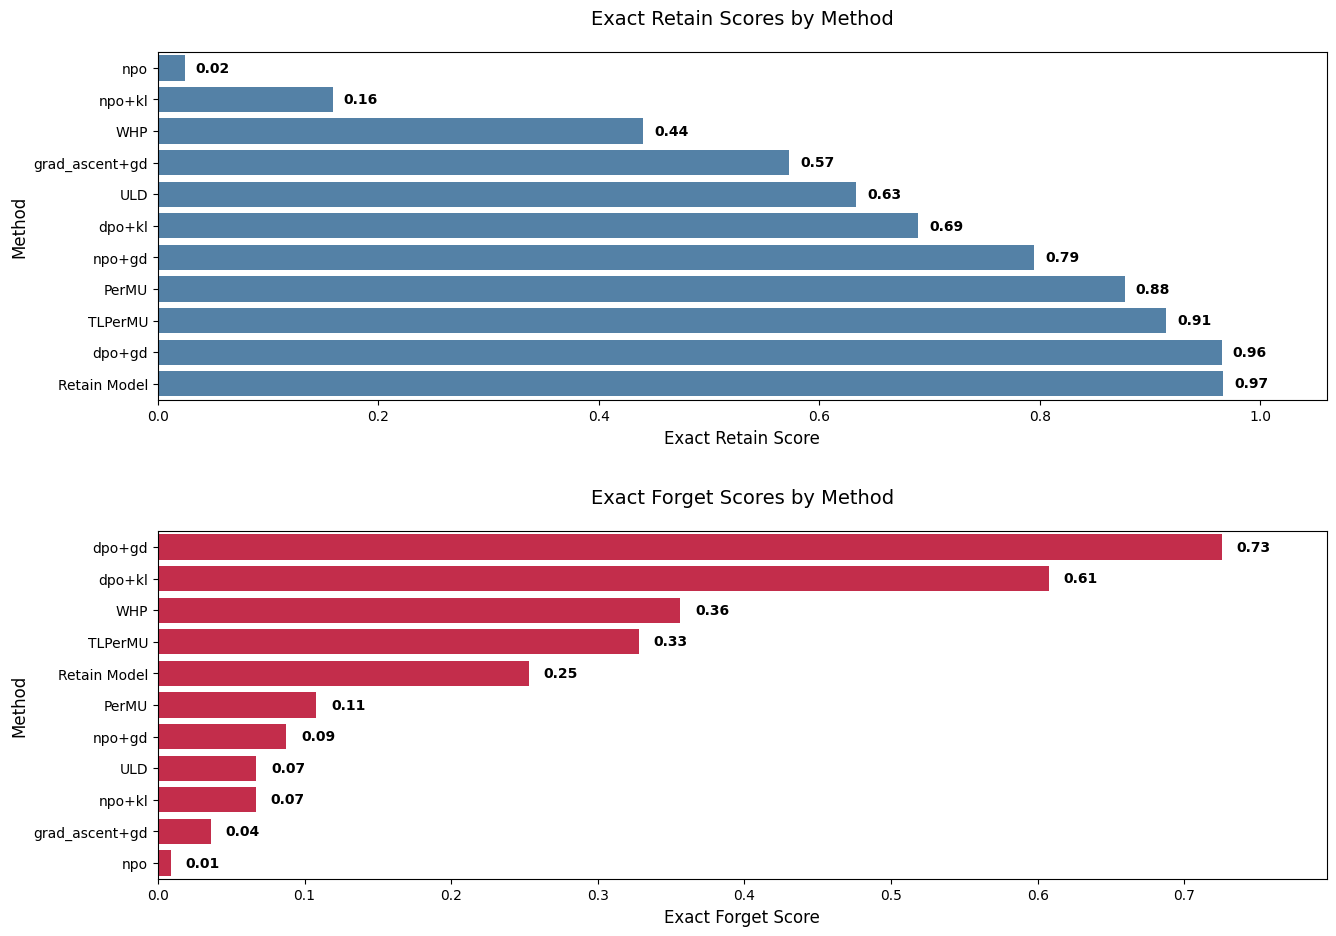

In [46]:
plot_retain_forget_scores_horizontal(full_df, 'Prob. Retain', 'Prob. Forget')

Right away, we can see that only the PerMU methods, gard_ascent and dpo are able to effectively forget the bulk of the information. It is important to note that that PerMU performs better at the forget metric than PerMUintext, but PermUintext has a slightly higher retain score.

#### Paraphrased Questiosn Eval Metrics


The paraphrsed QA is introduced by the UGBench papaer to recitify the very obvious mistake the other papers made, overfitting to the specific example.

**Total Samples (Normalizing Constant):**

- Forget ( 200 rows)
- Test_retain (250 rows)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


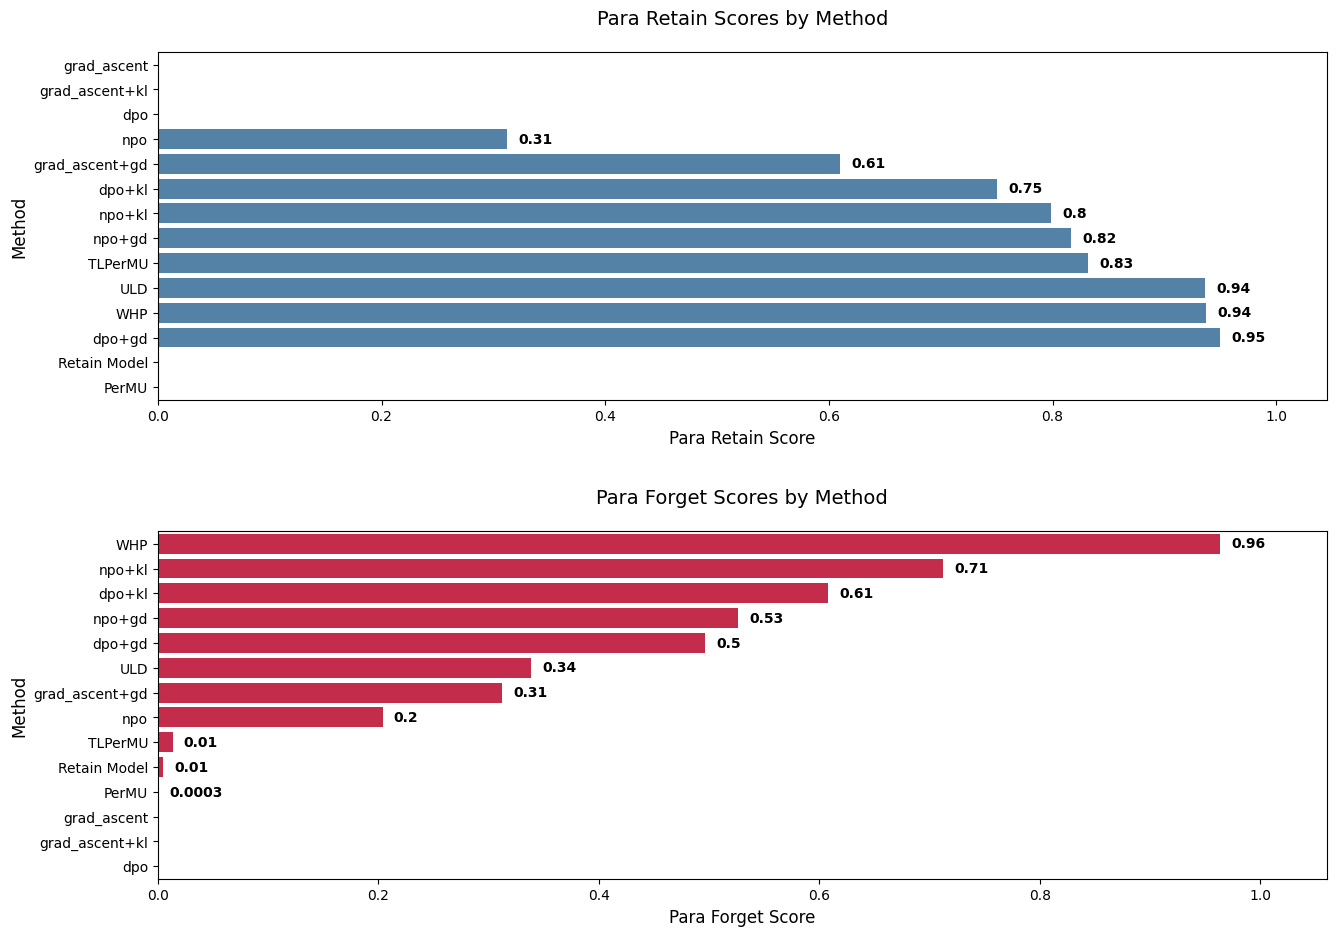

In [42]:
plot_retain_forget_scores_horizontal(full_df, 'para_scores_retain_exact', 'para_scores_forget_exact', title_prefix='Para')

We see mostly the same trend for the paraphrased methods, where PermU and PerMUintext are by far the best methods, with PerMU having a (slightly) better forget score, and PerMUintext having a (slightly) better retain score.

**NOTE**: Here we can see the downside of a method like ULD. For the DirectQA it had a pretty good Forget Score (0.18 leaked), while the paraphrased were able to leak much more PII (0.34). It is somewhat important to note though, that the ULD method has a substantially better retain score than PerMU

#### Extraction Attack

- Forget : 200
- Test_retain : 250

In [ ]:
full_df[['method','pii_extraction_leakage_rate_retain_exact','pii_extraction_leakage_rate_forget_exact','pii_targetted']]

,method,pii_extraction_leakage_rate_retain_exact,pii_extraction_leakage_rate_forget_exact
1,ULD,0.000000,0.0000
2,WHP,0.000000,0.0000
4,grad_ascent+gd,0.000000,0.0000
6,dpo+kl,0.001111,0.0050
7,dpo+gd,0.000556,0.0050
8,npo,0.000556,0.0100
9,npo+kl,0.000556,0.0000
10,npo+gd,0.001111,0.0050
11,TLPerMU,0.000611,0.0045
12,Retain Model,0.000000,0.0200


#### Targetted Attack comparison

**Total Samples (Normalizing Constant):**

- Forget : 10
- Test_Retain: 30

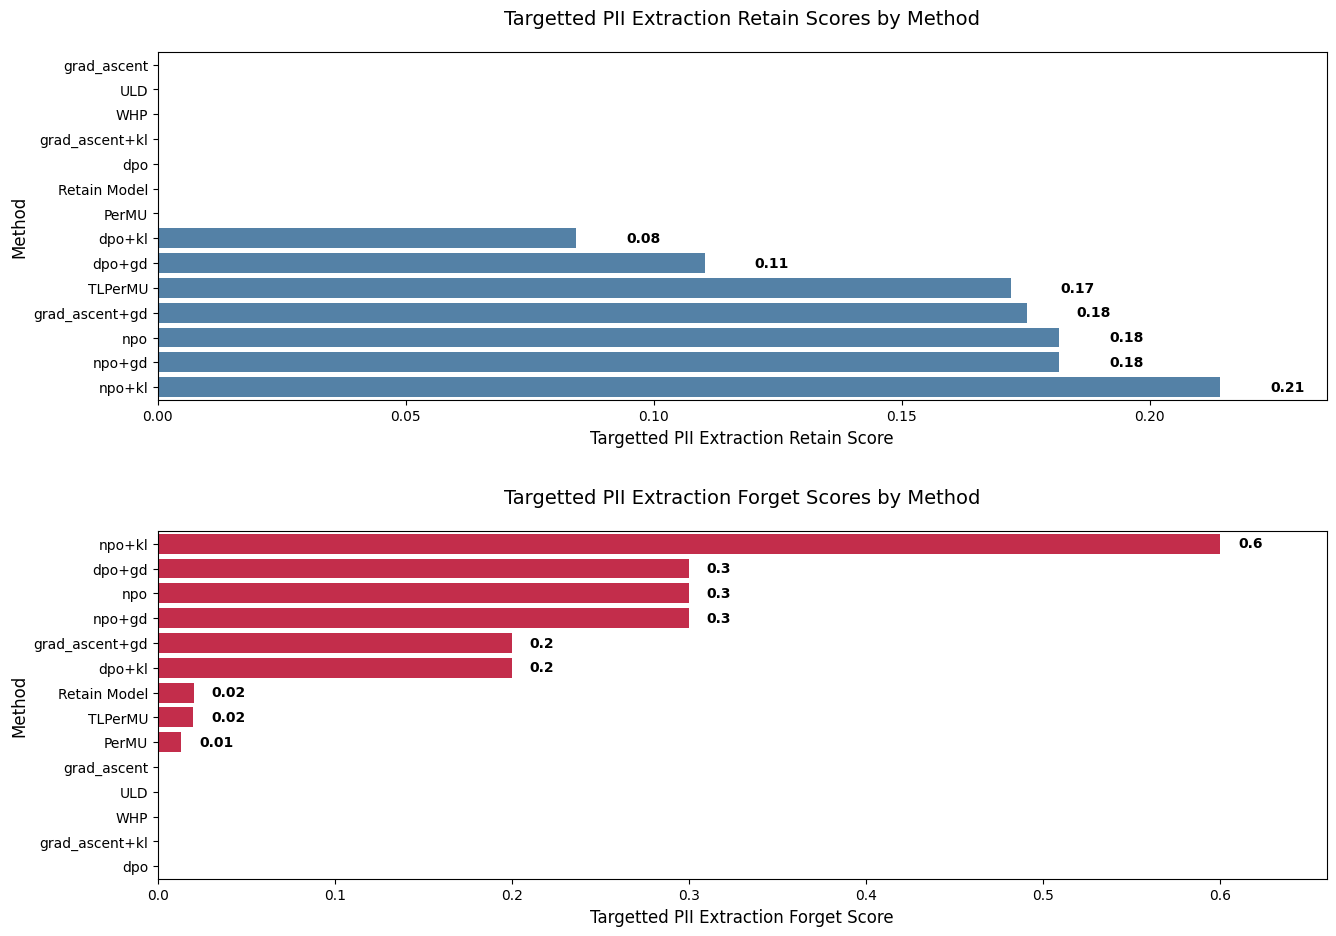

In [62]:
plot_retain_forget_scores_horizontal(full_df, 'targeted_pii_extraction_leakage_rate_retain_exact', 'targeted_pii_extraction_leakage_rate_forget_exact', title_prefix='Targetted PII Extraction')

In [ ]:
plot_retain_forget_scores_horizontal(full_df, 'targeted_pii_extraction_leakage_rate_retain_exact', 'targeted_pii_extraction_leakage_rate_forget_exact', title_prefix='Targetted PII Extraction')

In [12]:
renamed_df = full_df.rename(columns={
    'exact_retain_score': 'Direct',
    'para_scores_retain_exact': 'Paraphrased',
    'one_hop_scores_retain_pii': 'OneHop',
    'inverse_scores_retain_exact': 'Inverted',            
    'pii_extraction_leakage_rate_retain_exact': 'Naive',
    'targeted_pii_extraction_leakage_rate_retain_exact': 'Targeted',
})

In [72]:
renamed_df = full_df.rename(columns={
    'exact_forget_score': 'Direct',
    'para_scores_forget_exact': 'Paraphrased',
    'one_hop_scores_forget_pii': 'OneHop',
    'inverse_scores_forget_exact': 'Inverted',            
    'pii_extraction_leakage_rate_forget_exact': 'Naive',
    'targeted_pii_extraction_leakage_rate_forget_exact': 'Targeted',
})

In [14]:
renamed_df.loc[renamed_df['method']=='TLPerMU','method']  = 'PerMUtok'

In [16]:
renamed_df[['method','Direct', 'Paraphrased', 'OneHop', 'Inverted']]

,method,Direct,Paraphrased,OneHop,Inverted
0,grad_ascent,0.000000,0.000000,0.000000,0.0000
1,ULD,0.930667,0.936267,0.000000,0.3000
2,WHP,0.938000,0.937333,0.000000,0.3080
3,grad_ascent+kl,0.000000,0.000000,0.000000,0.0000
4,grad_ascent+gd,0.628667,0.609867,0.130435,0.1440
5,dpo,0.000000,0.000000,0.000000,0.0000
6,dpo+kl,0.806667,0.750267,0.202899,0.2560
7,dpo+gd,0.992667,0.950133,0.362319,0.2680
8,npo,0.375333,0.312133,0.101449,0.2360
9,npo+kl,0.746667,0.798400,0.231884,0.3360


Some observations :

1. We see that ULD and WHP have 0 extractions for both the retain set and forget set, this is because they generated the EOS token right away, I believe this is point against their generizability, especially keeping in mind that the retain set is suppoed to have some values.
2. Surprisingly, the PermUintext methods seems to leak less PII than the PerMU method. Important to note that I ran PerMUintext 10 times and this is the average of that, while PerMU ran only once (as per the paper)
3. The NPO+KL method has much higher lekage for the forget set, as do most of the other methods here, presumably this is due to the very low number of forget PII here (and possible the nature of the PII).


#### One-hop Results


**Total Samples (Normalizing Constant):**

- Forget : 53
- Test_retain : 69

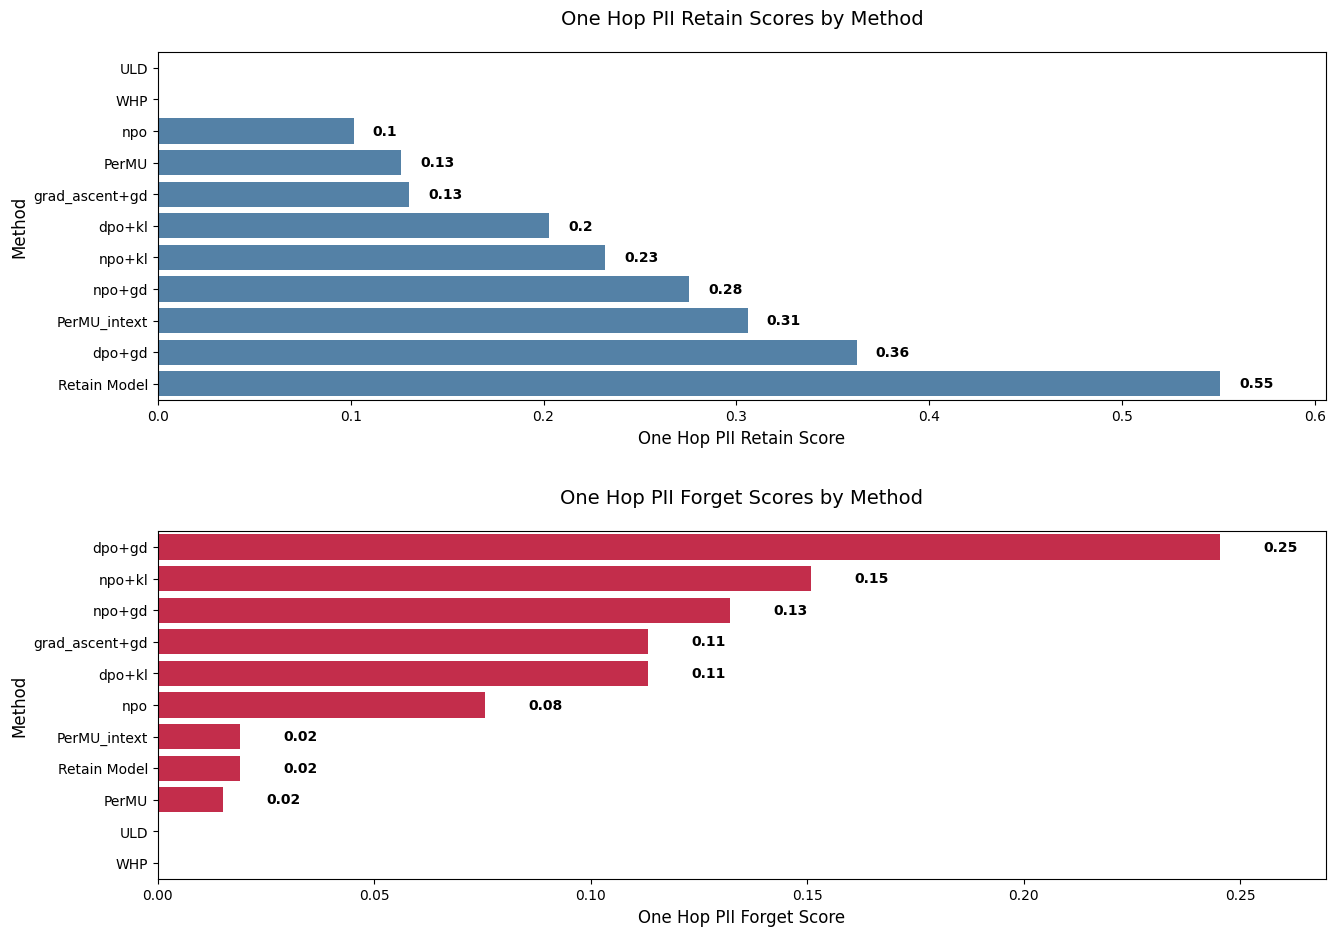

In [30]:
plot_retain_forget_scores_horizontal(full_df, 'one_hop_scores_retain_pii', 'one_hop_scores_forget_pii', title_prefix='One Hop PII')

1. Again ULD and WHP outputted nothing
2. Again, PerMU intext performs better than PerMU surprisingly. But this time, there are way more than 10 samples, so that is interesting to see.

#### Inverse Attack comparison

- Forget: 200
- Test_Retain : 250

posx and posy should be finite values
posx and posy should be finite values


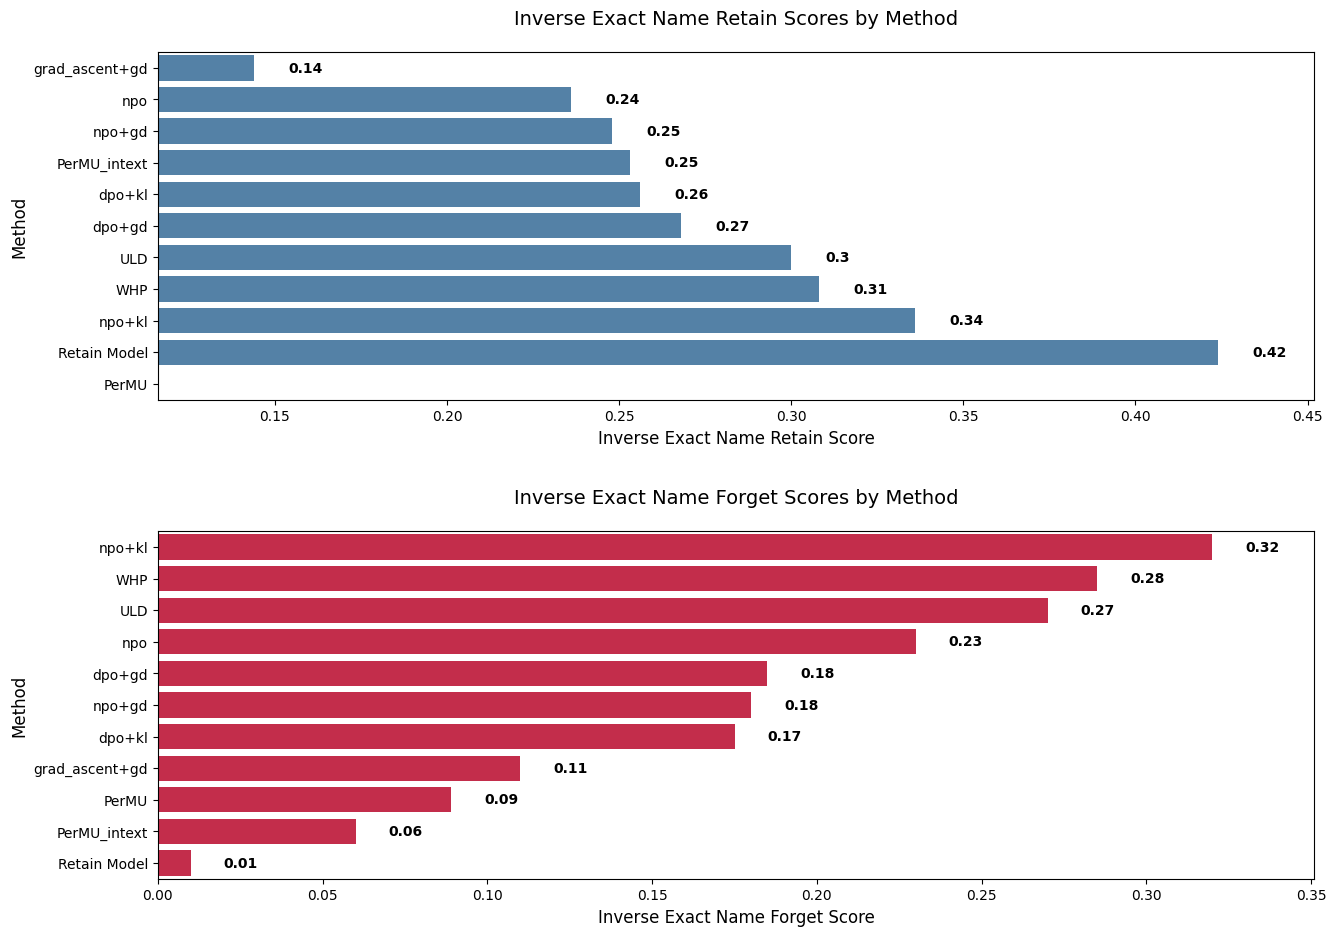

In [ ]:
plot_retain_forget_scores_horizontal(full_df, 'inverse_scos_retain_exact', 'inverse_scores_forget_exact', title_prefix='Inverse Exact Name')

Once again, it is very surprising to see that the PerMUintext method leaks less values than PerMU.

#### Averaging all of the metrics with Equal Weight

In [43]:
retain_columns = [
   # 'exact_retain_score', 
   # 'para_scores_retain_exact', 
   # 'pii_extraction_leakage_rate_retain_exact',
    'targeted_pii_extraction_leakage_rate_retain_exact',
    'one_hop_scores_retain_pii',
    'inverse_scores_retain_exact'
]

forget_columns = [
   # 'exact_forget_score',
   # 'para_scores_forget_exact',
   #'pii_extraction_leakage_rate_forget_exact',
    'targeted_pii_extraction_leakage_rate_forget_exact', 
    'one_hop_scores_forget_pii',
    'inverse_scores_forget_exact'
]

# Calculate mean for retain scores
full_df['avg_retain_score'] = full_df[retain_columns].mean(axis=1)
full_df['avg_forget_score'] = full_df[forget_columns].mean(axis=1)


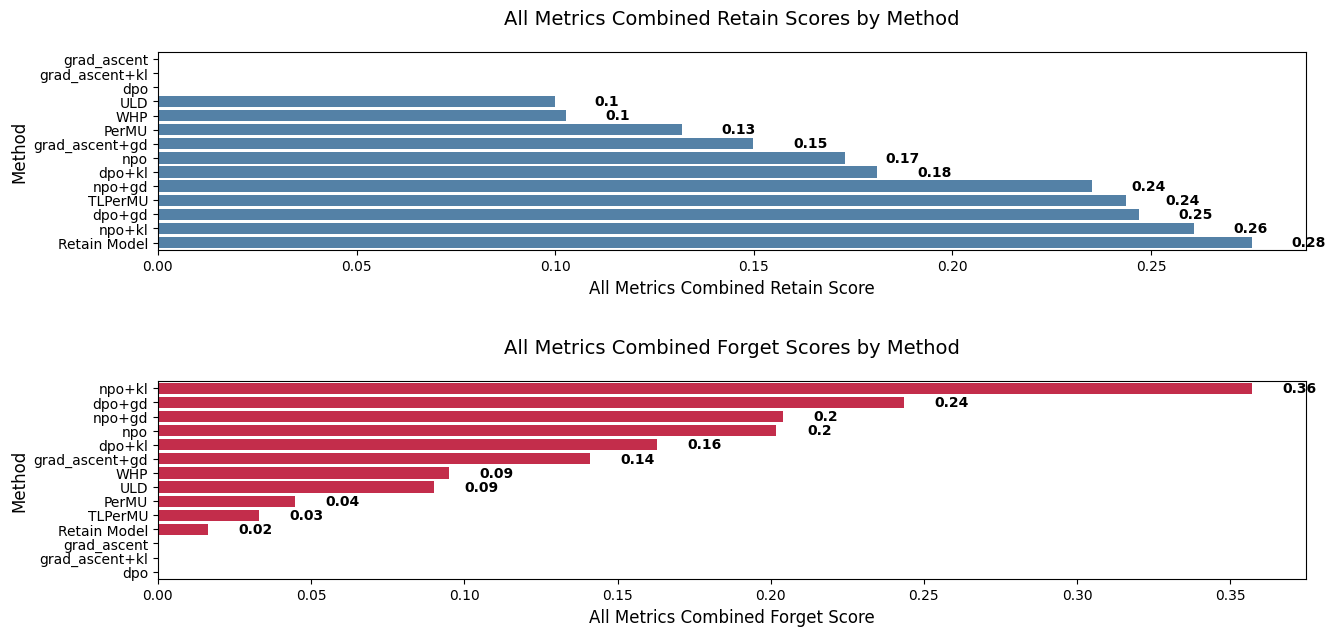

In [44]:
plot_retain_forget_scores_horizontal(full_df, 'avg_retain_score', 'avg_forget_score', title_prefix="All Metrics Combined", figsize=(14, 7), adaptive_range=False)

Surprisingly, the PerMUintext method has better overall forget scores than the PerMU method, it also has much better overall retain scores. This is interesting and suprising to see, as I expected the default PerMU method to be better at generizability, as it corrupts the more 'in-context' representation of subject, with the shared limitation that the noise is attributed to tokens separately rather than entire subject.

#### TOFU Metrics : Model Utility & Forget Fluency

In [25]:
import numpy as np
from scipy.stats import hmean

def calculate_model_utility(df):
    """Calculate Model Utility as harmonic mean of all specified metrics."""
    
    utility_columns = [
        'Prob. Retain', 'ROUGE Retain', 'Truth Ratio Retain',
        'ROUGE Real Authors', 'Prob. Real Authors', 'Truth Ratio Real Authors',
        'Prob. Real World', 'ROUGE Real World', 'Truth Ratio Real World'
    ]
    
    existing_columns = [col for col in utility_columns if col in df.columns]
    df_copy = df.copy()
    
    # Ensure positive values for harmonic mean
    for col in existing_columns:
        df_copy[col] = np.maximum(df_copy[col], 1e-10)
    
    df_copy['Model Utility'] = df_copy[existing_columns].apply(lambda row: hmean(row.values), axis=1)
    return df_copy
full_df = calculate_model_utility(full_df)

In [32]:
full_df[[col for col in full_df.columns if 'Truth' in col]]

,Truth Ratio Forget Paraphrase,Truth Ratio Retain Paraphrase,Truth Ratio Retain,Truth Ratio Real Authors,Truth Ratio Real World,Truth Ratio Forget
1,0.313990,0.825235,0.842885,0.728996,0.640489,0.363040
2,0.159214,0.833103,0.852762,0.692818,0.595505,0.141424
4,0.164830,0.852138,0.883160,0.803259,0.629374,0.153934
6,0.174454,0.820952,0.835463,0.787536,0.706497,0.163365
7,0.160502,0.837474,0.854634,0.762702,0.655779,0.145282
8,0.161231,0.810553,0.847853,0.736206,0.603646,0.149654
9,0.154278,0.829177,0.850865,0.642168,0.575490,0.146808
10,0.157231,0.846277,0.865726,0.717009,0.567689,0.146709
11,0.533510,0.716639,0.739458,0.750534,0.661805,0.533833
12,0.403238,0.845344,0.864466,0.791195,0.718518,0.396621


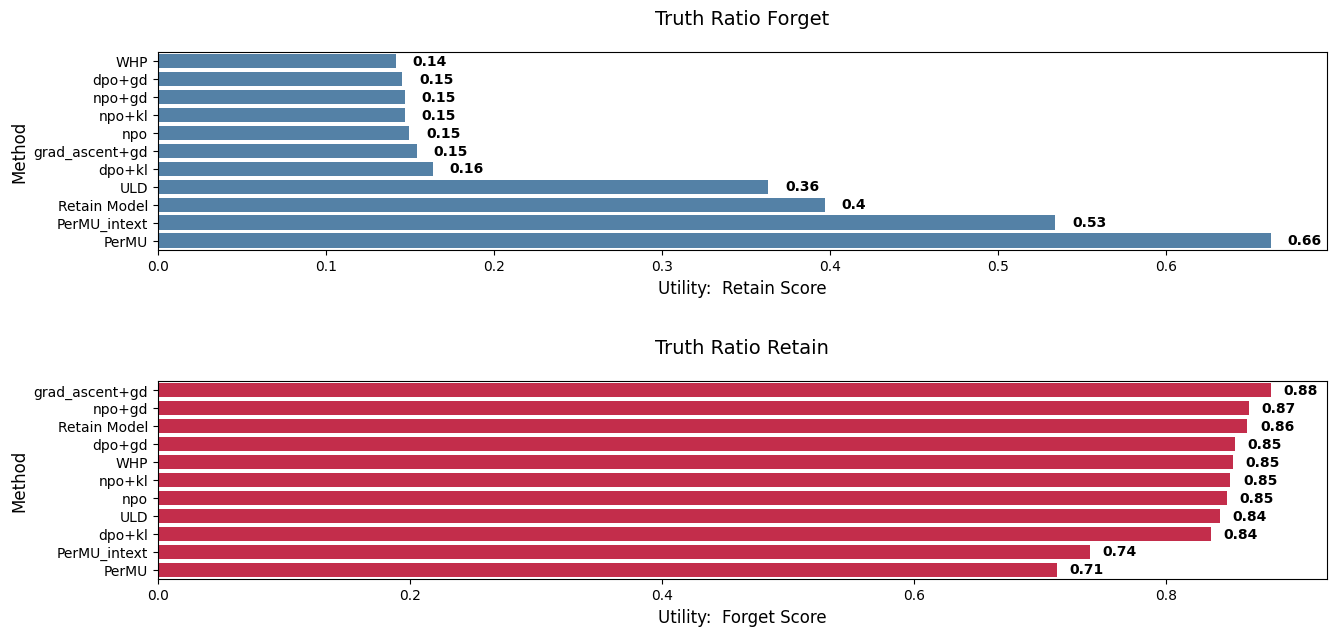

In [34]:
plot_retain_forget_scores_horizontal(full_df, 'Truth Ratio Forget', 'Truth Ratio Retain',retain_title='Truth Ratio Forget', forget_title='Truth Ratio Retain', title_prefix="Utility: ", figsize=(14, 7), adaptive_range=False)

In [50]:
import numpy as np
from scipy.stats import hmean

def calculate_model_utility(df):
    """Calculate Model Utility as harmonic mean of all specified metrics."""
    
    utility_columns = [
        'exact_retain_score', 'partial_ratio_retain_score', 'token_set_ratio_retain_score',  # Triple weight
        'ROUGE Real Authors', 'Prob. Real Authors', 'Truth Ratio Real Authors',
        'Prob. Real World', 'ROUGE Real World', 'Truth Ratio Real World'
    ]
    
    existing_columns = [col for col in utility_columns if col in df.columns]
    df_copy = df.copy()
    
    # Ensure positive values for harmonic mean
    for col in existing_columns:
        df_copy[col] = np.maximum(df_copy[col], 1e-10)
    
    df_copy['Model Utility'] = df_copy[existing_columns].apply(lambda row: hmean(row.values), axis=1)
    return df_copy
full_df = calculate_model_utility(full_df)

In [51]:
reduced_df = full_df[full_df['method'].isin(['TLPerMU', 'PerMU', 'Retain Model'])]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_retain_forget_scores_horizontal(df, retain_col, forget_col, third_col, cat_col="method", title_prefix="Exact", figsize=(18, 15), adaptive_range=True, retain_title=None, forget_title=None, third_title=None):
    """
    Plot retain, forget, and third column scores using horizontal bar plots for better label readability.
    """
    # Create figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=figsize)
    
    # Reset index to make config a column if it's currently the index
    plot_df = df[[retain_col, forget_col, third_col, cat_col]].reset_index()
    # Sort data for retain scores (increasing order)
    retain_order = plot_df.sort_values(retain_col)[cat_col].tolist()
    # Sort data for forget scores (decreasing order)
    forget_order = plot_df.sort_values(forget_col, ascending=False)[cat_col].tolist()
    # Sort data for third column scores (decreasing order - adjust as needed)
    third_order = plot_df.sort_values(third_col, ascending=False)[cat_col].tolist()
    # Plot 1: Retain Scores (Green) - Horizontal bars
    sns.barplot(data=plot_df, y=cat_col, x=retain_col, ax=ax1, color='forestgreen', order=retain_order)
    if retain_title is not None:
        ax1.set_title(retain_title, fontsize=14, pad=20)
    else:
        ax1.set_title(f'{title_prefix} Retain Scores by {cat_col.capitalize()}', fontsize=14, pad=20)
    ax1.set_ylabel(cat_col.capitalize(), fontsize=12)
    ax1.set_xlabel(f'{title_prefix} Retain Score', fontsize=12)
    
    # Add score labels at the end of retain bars
    for i, category in enumerate(retain_order):
        value = plot_df[plot_df[cat_col] == category][retain_col].iloc[0]
        # Smart formatting: show up to 4 decimals only if needed to avoid showing 0
        if value == 0:
            formatted_value = ' '
        elif f'{value:.2f}'.rstrip('0').rstrip('.') == '0':
            # If 2 decimals would show as 0, use up to 4 decimals
            formatted_value = f'{value:.4f}'.rstrip('0').rstrip('.')
        else:
            # Otherwise use up to 2 decimals
            formatted_value = f'{value:.2f}'.rstrip('0').rstrip('.')
        ax1.text(value + 0.01, i, formatted_value, 
                va='center', ha='left', fontsize=10, fontweight='bold')
    
    # Plot 2: Forget Scores (Blue) - Horizontal bars
    sns.barplot(data=plot_df, y=cat_col, x=forget_col, ax=ax2, color='steelblue', order=forget_order)
    if forget_title is not None:
        ax2.set_title(forget_title, fontsize=14, pad=20)
    else:
        ax2.set_title(f'{title_prefix} Forget Scores by {cat_col.capitalize()}', fontsize=14, pad=20)
    ax2.set_ylabel(cat_col.capitalize(), fontsize=12)
    ax2.set_xlabel(f'{title_prefix} Forget Score', fontsize=12)
    
    # Add score labels at the end of forget bars
    for i, category in enumerate(forget_order):
        value = plot_df[plot_df[cat_col] == category][forget_col].iloc[0]
        # Smart formatting: show up to 4 decimals only if needed to avoid showing 0
        if value == 0:
            formatted_value = ' '
        elif f'{value:.2f}'.rstrip('0').rstrip('.') == '0':
            # If 2 decimals would show as 0, use up to 4 decimals
            formatted_value = f'{value:.4f}'.rstrip('0').rstrip('.')
        else:
            # Otherwise use up to 2 decimals
            formatted_value = f'{value:.2f}'.rstrip('0').rstrip('.')
        ax2.text(value + 0.01, i, formatted_value, 
                va='center', ha='left', fontsize=10, fontweight='bold')
    
    # Plot 3: Third Column Scores (Red) - Horizontal bars
    sns.barplot(data=plot_df, y=cat_col, x=third_col, ax=ax3, color='crimson', order=third_order)
    if third_title is not None:
        ax3.set_title(third_title, fontsize=14, pad=20)
    else:
        ax3.set_title(f'{title_prefix} {third_col.capitalize()} Scores by {cat_col.capitalize()}', fontsize=14, pad=20)
    ax3.set_ylabel(cat_col.capitalize(), fontsize=12)
    ax3.set_xlabel(f'{title_prefix} {third_col.capitalize()} Score', fontsize=12)
    
    # Add score labels at the end of third column bars
    for i, category in enumerate(third_order):
        value = plot_df[plot_df[cat_col] == category][third_col].iloc[0]
        # Smart formatting: show up to 4 decimals only if needed to avoid showing 0
        if value == 0:
            formatted_value = ' '
        elif f'{value:.2f}'.rstrip('0').rstrip('.') == '0':
            # If 2 decimals would show as 0, use up to 4 decimals
            formatted_value = f'{value:.4f}'.rstrip('0').rstrip('.')
        else:
            # Otherwise use up to 2 decimals
            formatted_value = f'{value:.2f}'.rstrip('0').rstrip('.')
        ax3.text(value + 0.01, i, formatted_value, 
                va='center', ha='left', fontsize=10, fontweight='bold')
    
    # Adapt x-axis ranges if requested
    if adaptive_range:
        # For retain scores
        retain_min, retain_max = plot_df[retain_col].min(), plot_df[retain_col].max()
        retain_padding = (retain_max - retain_min) * 0.1
        x_min_retain = max(0, retain_min - retain_padding)
        ax1.set_xlim(x_min_retain, retain_max + retain_padding)
        
        # For forget scores
        forget_min, forget_max = plot_df[forget_col].min(), plot_df[forget_col].max()
        forget_padding = (forget_max - forget_min) * 0.1
        x_min_forget = max(0, forget_min - forget_padding)
        ax2.set_xlim(x_min_forget, forget_max + forget_padding)
        
        # For third column scores
        third_min, third_max = plot_df[third_col].min(), plot_df[third_col].max()
        third_padding = (third_max - third_min) * 0.1
        x_min_third = max(0, third_min - third_padding)
        ax3.set_xlim(x_min_third, third_max + third_padding)
    
    plt.tight_layout(pad=3.0)
    plt.show()

In [53]:
reduced_df[['method','exact_forget_score', 'partial_ratio_forget_score', 'token_set_ratio_forget_score']]

,method,exact_forget_score,partial_ratio_forget_score,token_set_ratio_forget_score
11,TLPerMU,0.011333,0.062083,0.017167
12,Retain Model,0.005000,0.099167,0.010000
13,PerMU,0.001417,0.034333,0.002417


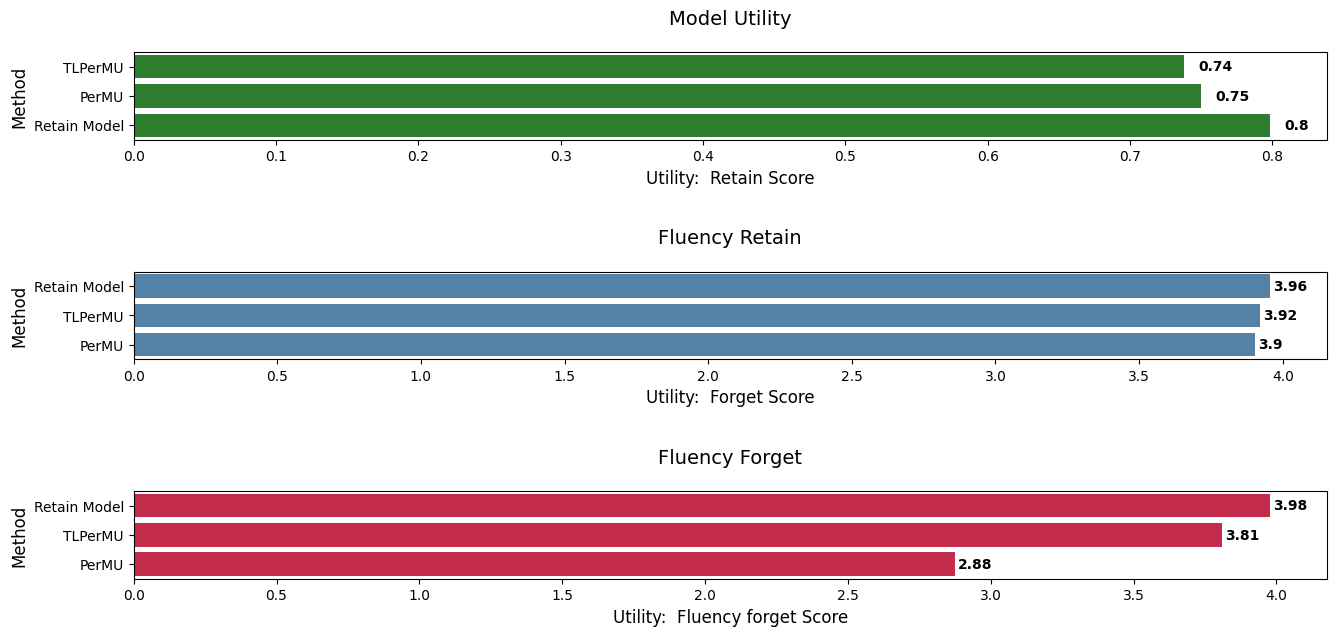

In [57]:
plot_retain_forget_scores_horizontal(reduced_df, 'Model Utility', 'Fluency Retain','Fluency Forget',retain_title='Model Utility', forget_title='Fluency Retain',third_title='Fluency Forget',title_prefix="Utility: ", figsize=(14, 7), adaptive_range=False)

1. Utility is overall comparable, at least when copmaring the methods that matter (PerMUintext and PerMU).

2. Fluency is quite a bit worse for PerMU.


Fluency Definition:  Fluency is measured by the
weighted average of bi- and tri-gram entropies [51], defined
as −
P
k
f(k) log2 f(k), where f(·) represents the n-gram
frequency distribution. A higher Fluency score indicates
more informative and diverse text generation.